# 1. Понимание бизнеса

## 1.1 Цель
Предсказать качество вина исходя из его показателей. 

## 1.2 Описание
Методы оценки качества вина, совокупность приемов, направленных на определение соответствующих типу вина отдельных показателей, обусловливающих его пригодность к употреблению. Оценка качества вина проводится различными методами в зависимости от предъявляемых к нему требований. Наиболее распространены аналитические методы: органолептический, химический, физико-химический, физический и микробиологический.

Химический метод основан на правилах объемного или весового анализа. С его помощью определяют титруемую кислотность, содержание сахаров, сернистой кислоты и др. показатели.

Благодаря предварительной оценки качества вина можно также выставить соответсвующую цену продукту, и предсказать насколько высоко оценён он будет на рынке. 

# 2. Data Understanding

## 2.1 Import Libraries

In [11]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd
import requests
import csv

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score 

# Modelling Helpers
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import  Normalizer , scale
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import auc, roc_curve, roc_auc_score
# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

## 2.2 Вспомогательные функции

In [2]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))
def show_auc(y, y_pred, plot_label='', prin=True):    
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc_val = auc(fpr, tpr)
    if prin:
        print('ROC AUC: {0:.4f}'.format(auc_val))
    if plot_label:
        plt.plot(fpr, tpr, label=plot_label)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    return auc_val
    

## 2.3 Загрузка данных и чистка

In [12]:
df = pd.read_csv("data/winequalityN.csv")
### Так как метод требует комплексной оценки показателей, а строк с проусками незначительное количество, то можно применить метод сброса строк с пропущенными значениями. 
df = df.dropna()


PermissionError: [Errno 13] Permission denied: 'data/winequalityN.csv'

In [17]:
import kaggle
kaggle.api.authenticate()
kaggle.api.dataset_download_files('rajyellow46/wine-quality', path='D:/Users/Doom/Documents/GitHub/NetologyPython/Mashine learning/Методология/Vines_kaggle/data', unzip=True)


## 2.4 Статистика и визуализации

In [4]:
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


**Описание переменных**

  - 'type': Тип вина - белое или красное 
  - 'fixed acidity':  большинство кислот, связанных с вином, фиксированные или нелетучие (не испаряются быстро)  - g / dm^3
  - 'volatile acidity': количество уксусной кислоты в вине, слишком высокое содержание которой может привести к неприятному вкусу уксуса.  - g / dm^3 
  - 'citric acid': лимонная кислота: в небольших количествах лимонная кислота может добавить винам свежесть и аромат.  - g / dm^3
  - 'residual sugar': количество сахара, оставшееся после остановки брожения, редко можно найти вина с концентрацией менее 1 грамма / литр, а вина с концентрацией более 45 граммов / литр считаются сладкими.  - g / dm^3
  - 'chlorides': количество соли в вине  - g / dm^3
  - 'free sulfur dioxide':  свободная форма SO2 находится в равновесии между молекулярным SO2 (в виде растворенного газа) и бисульфит-ионом; предотвращает рост микробов и окисление вина. (mg / dm^3)
  - 'total sulfur dioxide': количество свободной и связанной форм S02; в низких концентрациях SO2 в основном не обнаруживается в вине, но при концентрациях свободного SO2 более 50 ppm SO2 становится заметным в носу и вкусе вина. (mg / dm^3)
  - 'density': плотность воды близка к плотности воды в зависимости от процентного содержания спирта и сахара. (g / cm^3)
  - 'pH': описывает, насколько вино кислое или основное, по шкале от 0 (очень кислая) до 14 (очень щелочная); большинство вин имеют уровень pH от 3 до 4 
  - 'sulphates': винная добавка, которая может способствовать повышению уровня газообразного диоксида серы (SO2), который действует как антимикробное и антиоксидантное средство.  - g / dm^3
  - 'alcohol': процентное содержание алкоголя в вине.  (% by volume)

##### Выходная переменная (на основе сенсорных данных): 12 - качество (оценка от 0 до 10)
  


### 2.4.1 Далее взглянем на некоторую ключевую информацию о переменных

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6463 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6463 non-null   object 
 1   fixed acidity         6463 non-null   float64
 2   volatile acidity      6463 non-null   float64
 3   citric acid           6463 non-null   float64
 4   residual sugar        6463 non-null   float64
 5   chlorides             6463 non-null   float64
 6   free sulfur dioxide   6463 non-null   float64
 7   total sulfur dioxide  6463 non-null   float64
 8   density               6463 non-null   float64
 9   pH                    6463 non-null   float64
 10  sulphates             6463 non-null   float64
 11  alcohol               6463 non-null   float64
 12  quality               6463 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 706.9+ KB


In [6]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000
mean,7.217755,0.339589,0.318758,5.443958,0.056056,30.516865,115.694492,0.994698,3.218332,0.531150,10.492825,5.818505
std,1.297913,0.164639,0.145252,4.756852,0.035076,17.758815,56.526736,0.003001,0.160650,0.148913,1.193128,0.873286
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992330,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.997000,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


#### Стоит отметить, что в столбцах volatile acidity,residual sugar,residual sugar,chlorides,total sulfur dioxide,density разница может отличаться в 10ки раз. Поэтому считаю, что имеет смысл рассматривать каждыйю тип вина индивидуально.


In [7]:
types = df.type.unique()
print(types)

['white' 'red']


In [8]:
df_w = df[(df.type == "white")]
df_w.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4870.000000,4870.000000,4870.000000,4870.000000,4870.000000,4870.000000,4870.000000,4870.000000,4870.000000,4870.000000,4870.000000,4870.000000
mean,6.855123,0.278071,0.334199,6.394343,0.045771,35.317146,138.340144,0.994026,3.188154,0.489700,10.516772,5.878029
std,0.843444,0.100528,0.120915,5.070853,0.021846,17.012967,42.490515,0.002993,0.150902,0.114196,1.231251,0.885699
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991720,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993735,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [9]:
df_r = df[(df.type == "red")]
df_r.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000
mean,8.326365,0.527659,0.271551,2.538512,0.087497,15.841808,46.463905,0.996752,3.310590,0.657866,10.419617,5.636535
std,1.740681,0.179297,0.194843,1.412061,0.047134,10.436038,32.913696,0.001888,0.154305,0.169716,1.065206,0.807687
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997850,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Так как данные показатели в вышеупомянутых столбца в разных видах вина занчительно отличаются, что считаю целесообразным рассматривать их отдельно.

### 2.4.2 Тепловая карта корреляции может дать нам понимание того, какие переменные важны

### Для белого вина 

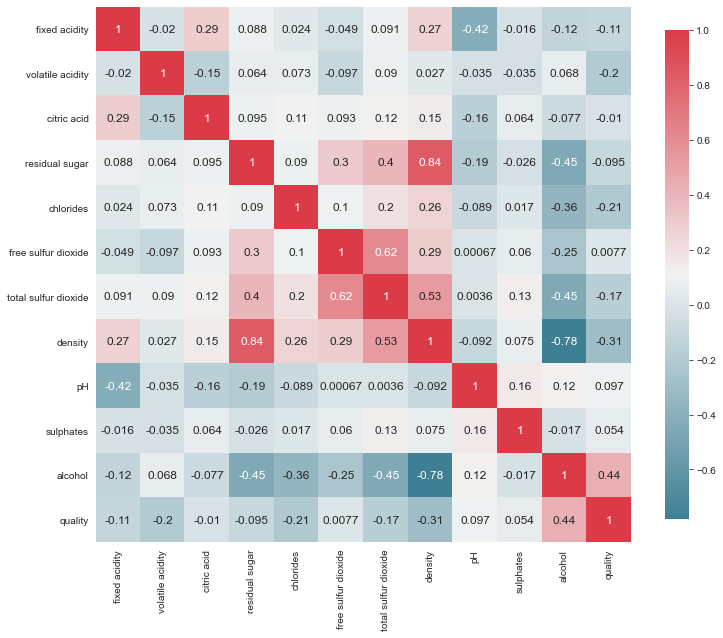

In [10]:
plot_correlation_map(df_w)

#### Взаимосвязь между признаками и оценкой вина 

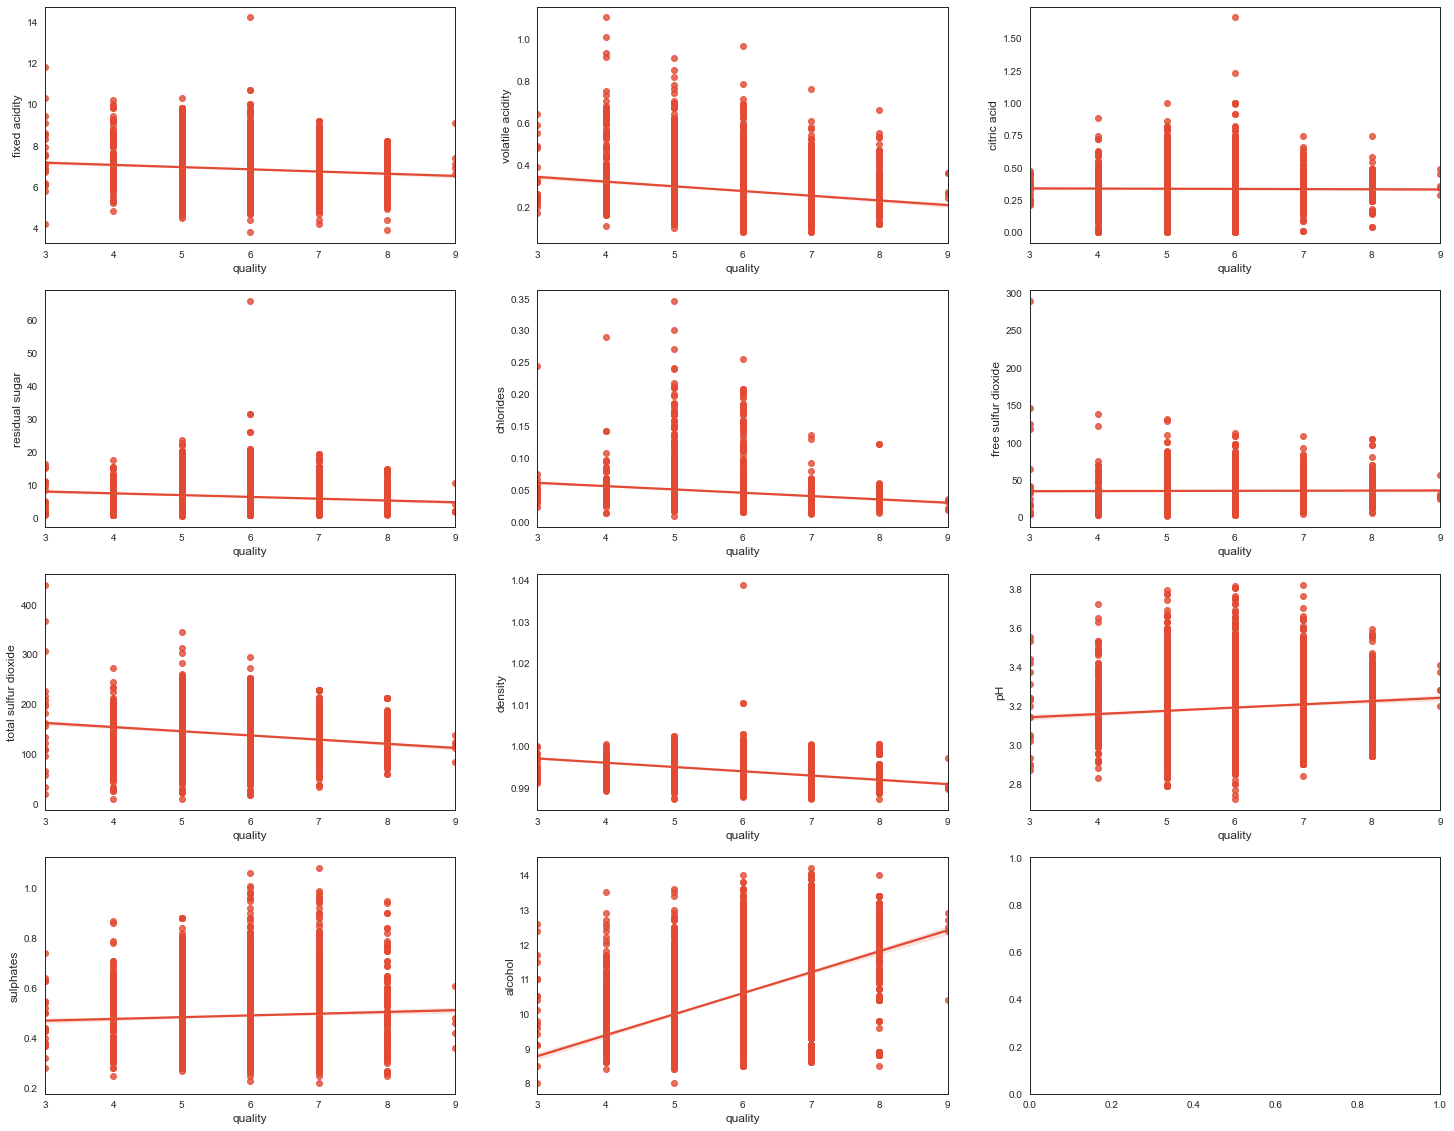

In [11]:
# Гистрограмма сравнения показателей и качества вина.
df_col = df.columns[1:-1]
f, x = plt.subplots(4, 3, figsize = (25, 20)) 
z = 0
list_ = []
while z < 4: 
    y = 0
    while y < 3: 
        l = []
        l.append(z)
        l.append(y)
        y+=1
        list_.append(l)
    z+=1
__ = 0 
for col in df_col:
    sns.regplot(x = df_w['quality'], y = df_w[col], ax = x[list_[__][0], list_[__][1]])
    __ += 1

### Для красного вина 

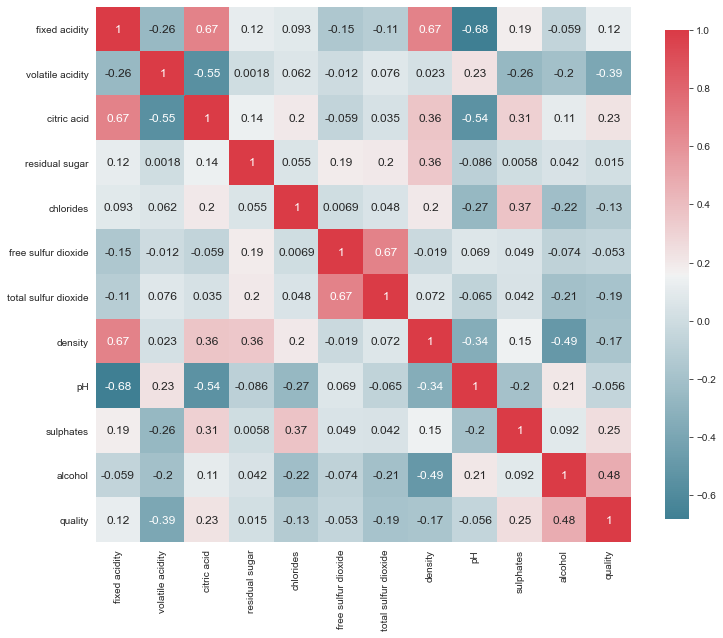

In [12]:
plot_correlation_map(df_r)

#### Взаимосвязь между признаками и оценкой вина 

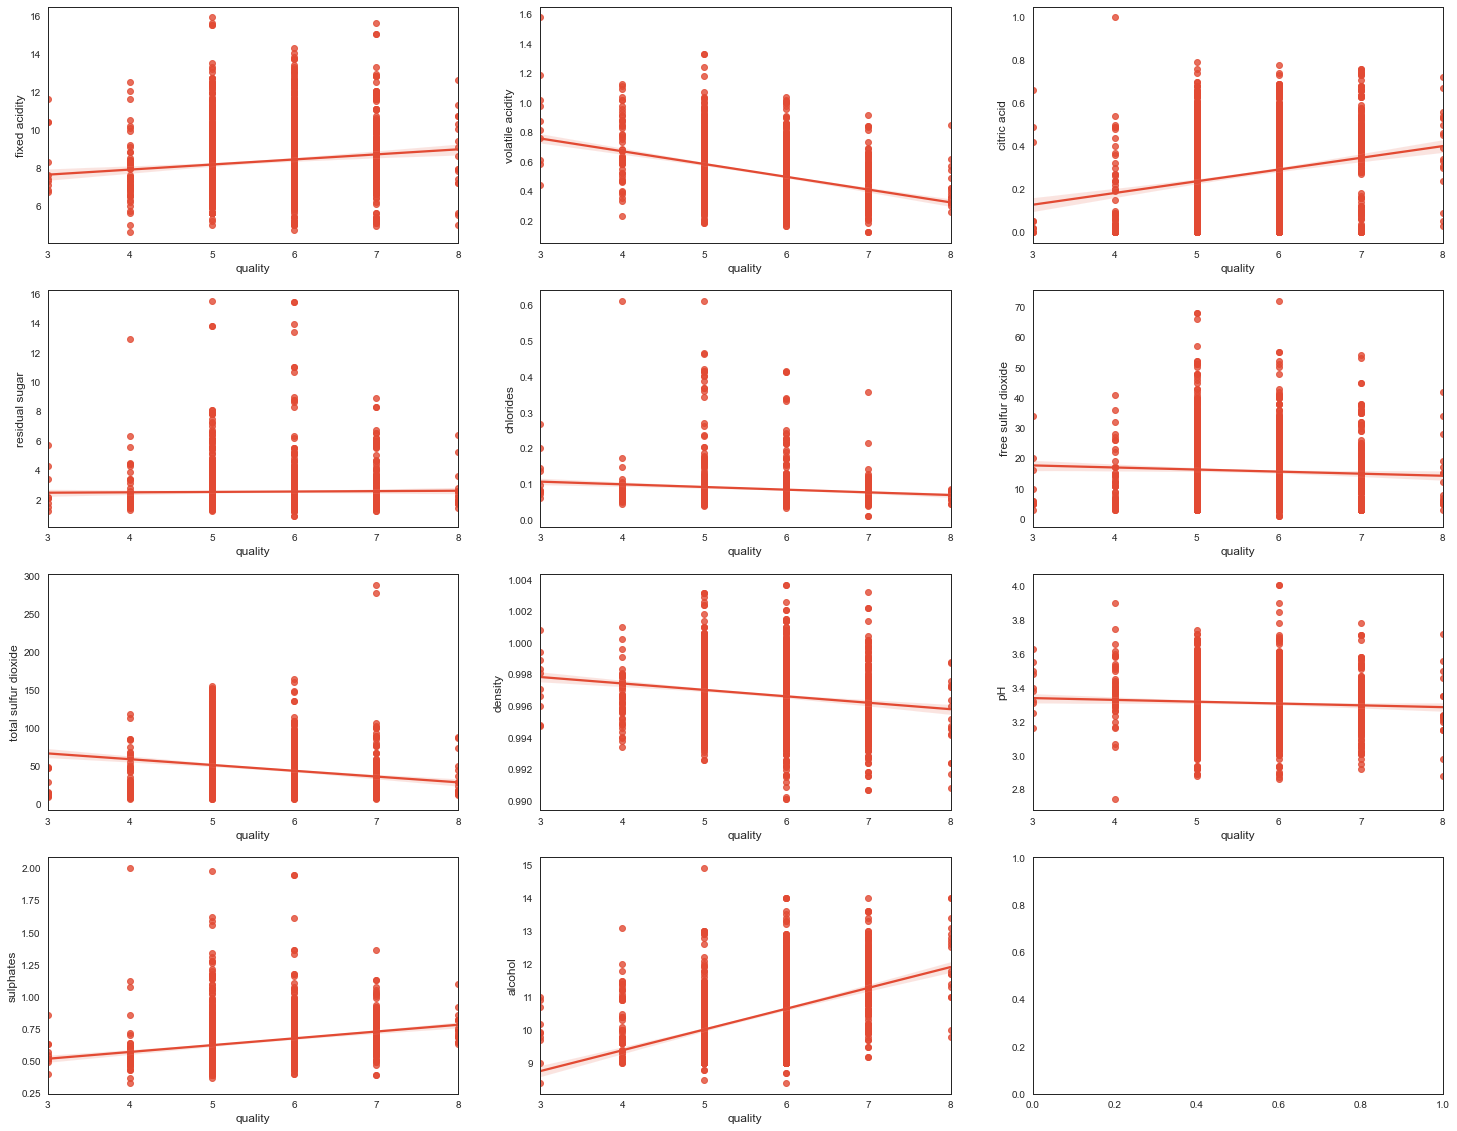

In [13]:
# Гистрограмма сравнения показателей и качества вина.
df_col = df.columns[1:-1]
f, x = plt.subplots(4, 3, figsize = (25, 20)) 
z = 0
list_ = []
while z < 4: 
    y = 0
    while y < 3: 
        l = []
        l.append(z)
        l.append(y)
        y+=1
        list_.append(l)
    z+=1
__ = 0 
for col in df_col:
    sns.regplot(x = df_r['quality'], y = df_r[col], ax = x[list_[__][0], list_[__][1]])
    __ += 1

### Таким образом для обоих видов вин:
#### Качество резко повышается при снижении volatile acidity 
#### Качество повышается с увеличением citric acid
#### Качество резко повышается с увеличением alcohol

# 3. Подготовка данных к обучению

### Работа с категориальными величинами: 

In [14]:
selectedColumns = df['type']
X = pd.get_dummies( df, columns = ['type'] )

### Разбиваем данные на тестовую и тренировочную выборки.

In [15]:
y = X['quality']
del X['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# 4. Моделирование
Теперь мы выберем модель, которую хотели бы попробовать. Используем обучающий набор данных для обучения модели и затем проверим ее с помощью тестового набора.

## 3.1 Выбор модели
Хорошей отправной точкой является стэкинг.

Разбиваем данные на тестовую и тренировочную выборки.

In [16]:
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
estimators = [
    ('lr', RidgeCV()),
    ('svr', LinearSVR(random_state=421) )]
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=10,
                                          random_state=42))

In [17]:
reg.fit(X_train, y_train)
res = reg.predict(X_test)
res = list(res)
res_rounded = []
for x in res: 
    res_rounded.append(round(x, 0))

# 5. Оценка
Теперь мы собираемся оценить модель

## 5.1 Модель
Мы можем оценить точность модели, используя набор для валидации, где мы знаем фактический результат. Этот набор данных не использовался для обучения, поэтому он абсолютно новый для модели.

Затем мы сравниваем точность с точностью при использовании модели на тренировочных данных. Если разница между ними значительна, это свидетельствует о переобучении. Мы стараемся избегать этого, потому что это означает, что модель не будет хорошо обобщаться на новые данные (будет работать плохо)

In [18]:
scores_regr = metrics.mean_squared_error(y_test, res)
print(scores_regr)

0.7310705445544553


### Таким образом среднее квадратичное отклонение получилось около 0.65, что являеться весьма неплохим результатом для оценки качества данной продукции. 

## Развёртывание на кэгле не имеет смысла. 
# Спасибо за проверку! 